# Linear Regression

We have already used linear regression to make predictions about global tempurature anomaly and sea level rise. Now we will really dig into what's going on when we perform linear regression. This includes understanding a bit about the mathematics behind the computation (gradient descent), and taking a look at how regression is applied to real data (cross validation). 

## Problem Statement for 1-Dimensional Features

Let's work on a simple case of linear regression (we can generalize this later). In our linear regression problem, we start with a set $X = \{x_1,\ldots,x_n\}$ of *features* (or *explanatory variables*) and a set $Y = \{y_1,\ldots,y_n\}$ of *response variables*. Each $x_j$ and each $y_j$ is a real number. We suspect that the response variables are determined linearly by the features; that is, there exist numbers $m$ and $b$ such that
$$
y_j \approx m x_j + b
$$
for each $j$. Our goal is to determine the numbers $m$ and $b$. 

Of course, if the $y_j$ were given exactly by $m x_j + b$, then this would be extremely easy. However, our data is noisy, so we want to find the *best possible* $m$ and $b$. 

To state the problem precisely, define the *loss function*
$$
L(m,b) = \sum_{j=1}^n \left(m x_j + b - y_j\right)^2.
$$
This particular loss function is called the *sum of squared residuals (SSR)*. Our goal is to find the $m$ and $b$ which minimize the loss function. 
Since $X$ and $Y$ are fixed, this problem can be restated as something from Calc 3. Indeed, write the loss function as 
\begin{align*}
L(m,b) &= \sum_{j=1}^n m^2 x_j^2 + 2mbx_j - 2m x_j y_j + b^2 - 2b y_j + y_j^2 \\
&= \left(\sum_j x_j^2\right) m^2 + n b^2 + \left(2\sum_j x_j\right) mb + \left(-2\sum_j x_j y_j\right) m + \left(-2 \sum_j y_j \right) b + \sum_j y_j^2.
\end{align*}
This is just a degree-2 polynomial in $m$ and $b$, so our goal is to find the absolute minimum of a relatively simple function $L:\mathbb{R}^2 \rightarrow \mathbb{R}$. 

This function is guaranteed to have a unique minimum. We can see this by computing its Hessian matrix
$$
\left(\begin{array}{cc}
\frac{\partial^2 L}{\partial m^2} & \frac{\partial^2 L}{\partial m \partial b} \\
\frac{\partial^2 L}{\partial m \partial b} & \frac{\partial^2 L}{\partial m^2}
\end{array}\right) = 
2 \left(\begin{array}{cc}
\sum_j x_j^2 & \sum_j x_j \\
\sum_j x_j & n
\end{array}\right)
$$
The determinant of the Hessian is
$$
2n \sum_j x_j^2 - 2\left(\sum_j x_j \right)^2 = 2 \sum_{i \neq j} (x_i - x_j)^2 > 0
$$
(as there is at least one pair of distinct elements of $X$). Moreover, the diagonal entries of the Hessian are positive. It follows that the graph of $L$ looks like an upward-opening paraboloid and has a unique minimum.

Let's take a look at what's going on here, and introduce some code for plotting in 3D.

<IPython.core.display.Javascript object>


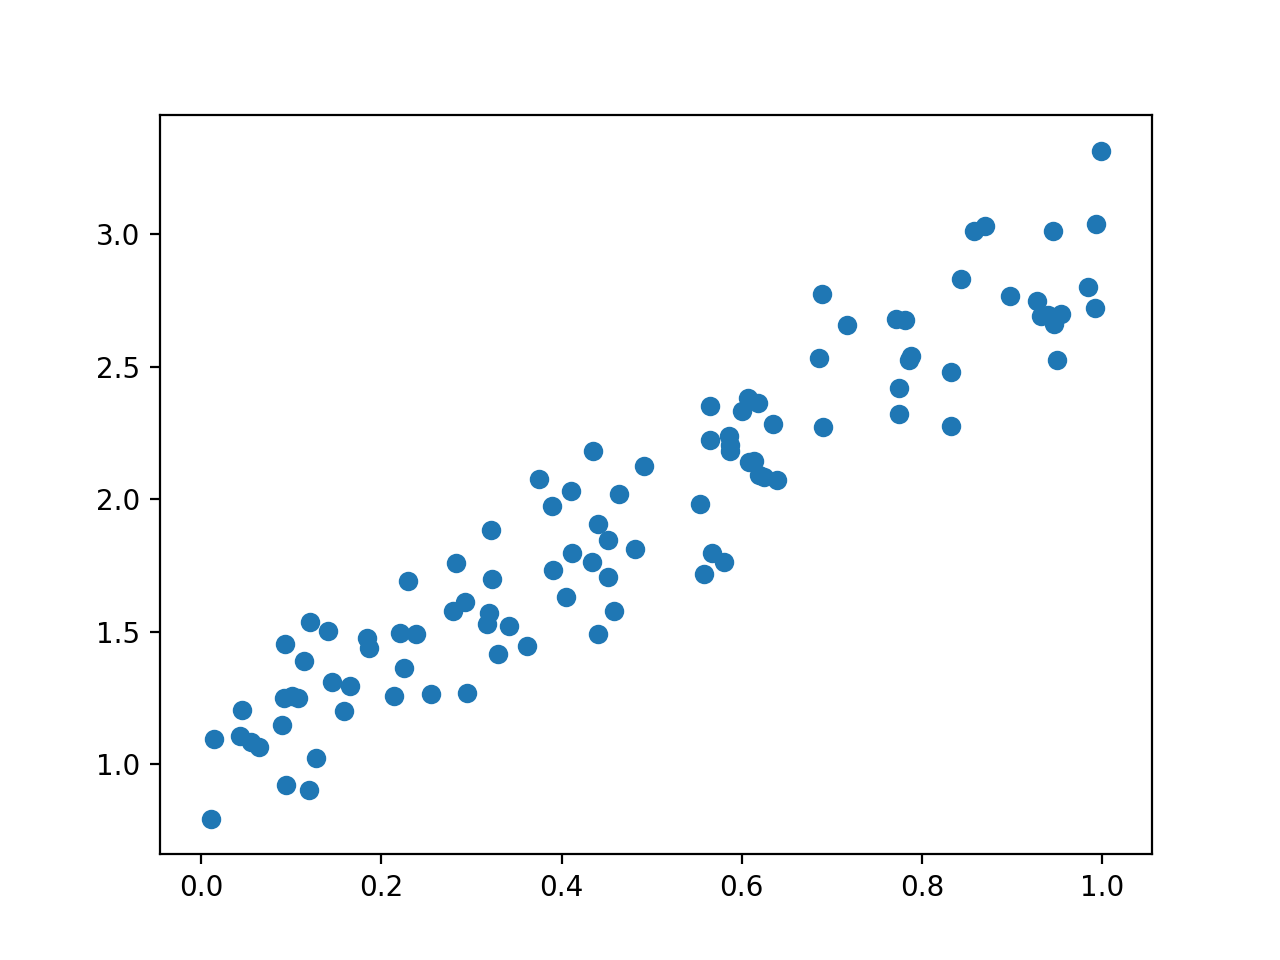

In [2]:
# Import packages
# We need a special package to plot in 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import random as r

# Make data.
X = [r.random() for j in range(100)] # A random string of numbers between 0 and 1
Y = [2*x + 1 + 0.5*(r.random()-r.random()) for x in X]
# Y values are really almost determined by a linear function of the X values
# Linear regression should return something close to m=2, b=1

# Plot the data
plt.scatter(X,Y);
plt.show()

<IPython.core.display.Javascript object>


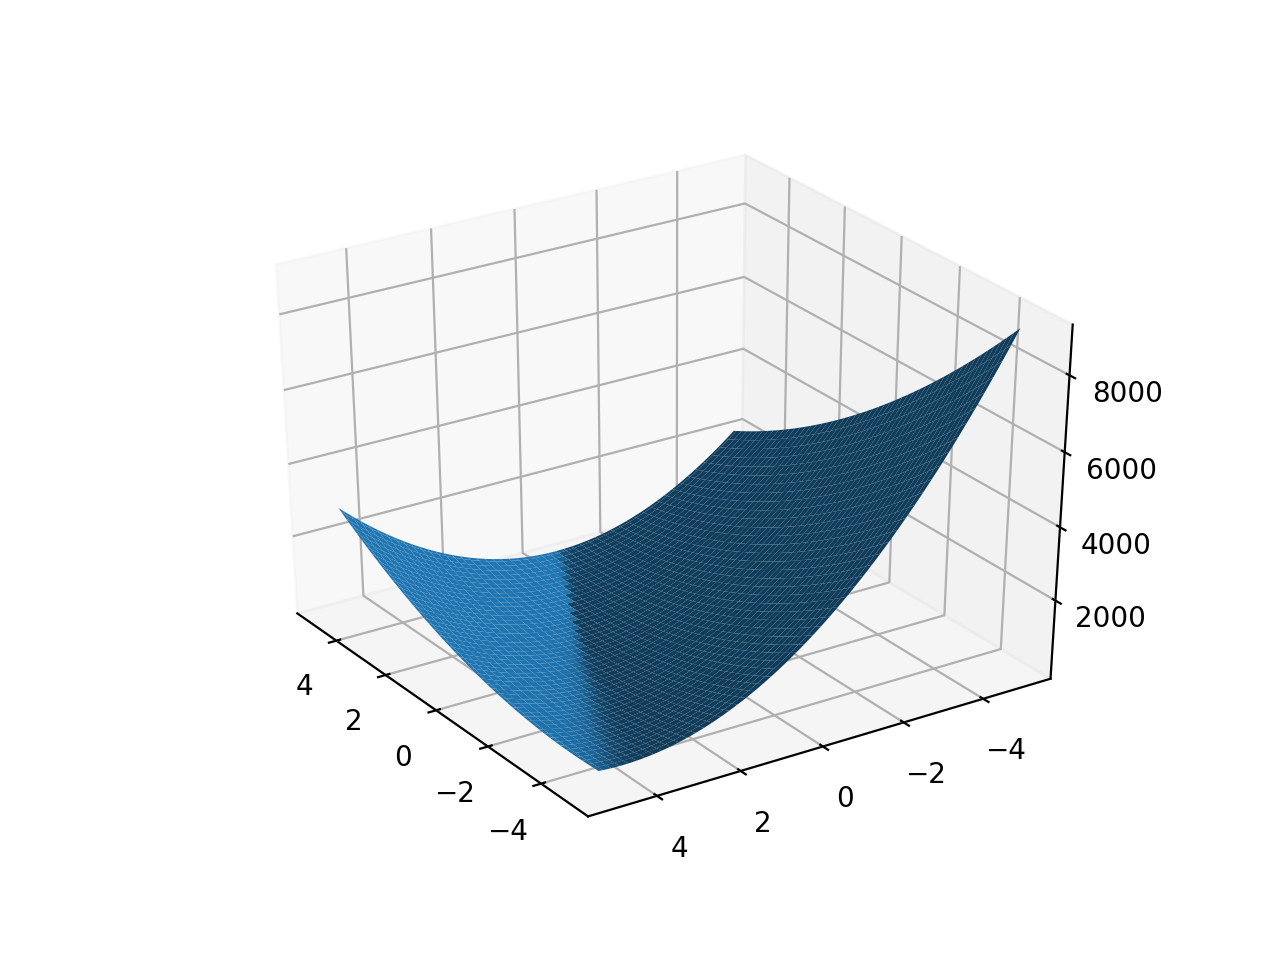

In [3]:
%matplotlib notebook
# Get the coefficients for our expression for L
coefs = [sum([x**2 for x in X]), len(X), 2*sum(X), -2*sum(np.array(X)*np.array(Y)), -2*sum(Y), sum([y**2 for y in Y])]

# Create a grid of m and b values to plot our surface over
m = np.arange(-5, 5, 0.1)
b = np.arange(-5, 5, 0.1)
m, b = np.meshgrid(m, b)

# Evaluate the loss function on all the points in the grid
L = coefs[0]*m**2 + coefs[1]*b**2 + coefs[2]*m*b + coefs[3]*m + coefs[4]*b + coefs[5]

# Create a figure and plot the surface
fig = plt.figure()

ax = fig.gca(projection='3d') #gca = get coordinate axes
surf = ax.plot_surface(m, b, L)

plt.show()

In [5]:
m

array([[-5. , -4.8, -4.6, ...,  4.4,  4.6,  4.8],
       [-5. , -4.8, -4.6, ...,  4.4,  4.6,  4.8],
       [-5. , -4.8, -4.6, ...,  4.4,  4.6,  4.8],
       ...,
       [-5. , -4.8, -4.6, ...,  4.4,  4.6,  4.8],
       [-5. , -4.8, -4.6, ...,  4.4,  4.6,  4.8],
       [-5. , -4.8, -4.6, ...,  4.4,  4.6,  4.8]])

We can use the following code to get the indices of the minimum of this surface.

In [10]:
ind = np.unravel_index(np.argmin(L, axis=None), L.shape)

Then we pull the slope and interecept at the minimum index.

In [11]:
m[ind], b[ind]

(1.9999999999999751, 0.9999999999999787)

## Gradient Descent

We can find the minimum of $L$ by the method of *gradient descent*. We pick a (small) step size $\eta > 0$ then design an algorithm to do the following:

Step 1:

Pick an initial pair $(m_0,b_0)$. This can be done randomly, or using some reasonable guess based on the data.

Step 2:

Compute the gradient $\nabla L (m_0,b_0)$. For this simple function, it is easy to show that the gradient is given in general by the formula
$$
\nabla L(m,b) = \left(\frac{\partial L}{\partial m} (m,b) , \frac{ \partial L}{\partial b} (m,b) \right) = \left( 2 \sum_j (m x_j + b - y_j) x_j, 2 \sum_j (m x_j + b - y_j) \right).
$$

Step 3:

Update $(m_1,b_1) = (m_0,b_0) - \eta \nabla L(m_0,b_0)$.

Step 4:

Iterate this procedure. Given a pair $(m_j,b_j)$, we update by the rule 
$$
(m_{j+1},b_{j+1}) = (m_j,b_j) - \eta \nabla L(m_j,b_j). 
$$
This is done until a *stopping condition* is met; usually a fixed number of iterations is reached, or the magnitude of the gradient falls below some chosen threshold.

In [33]:
# Import some useful packages
import random as r
import matplotlib.pyplot as plt
import numpy as np

# Define the loss function.
# Note the use of numpy to 'vectorize' some of the computations.
# This is a useful trick!
def loss(X,Y,m,b):
    L = m*np.array(X)+b - np.array(Y)
    return sum([x**2 for x in L])

# Define the gradient of the loss function.
# We are once again using numpy arrays to simplify some computations.
def gradient_loss(X,Y,m,b):
    L = m*np.array(X) + b - np.array(Y)
    return np.array([2*sum(L*np.array(X)),2*sum(L)])
    

# Define the linear regression function.
def linear_regression(X,Y,step_size = 1e-5, num_iter = 10000, 
                      gradient_threshold = 1e-10, verbose=True):
    # Initialize m and b with some reasonable guess
    m0 = (Y[-1]-Y[0])/(X[-1]-X[0])
    b0 = Y[0] - m0*X[0]
    P=[m0,b0]
    #P=[0,0]
    # We will keep track of all of the data in the process.
    # This is for explanatory purposes and not really necessary for the task.
    Losses = []
    Deltas = []
    SlopesIntercepts = []
    # Iterate the gradient updates
    for j in range(num_iter):
        SlopesIntercepts.append(P)
        Losses.append(loss(X,Y,P[0],P[1]))
        delta = gradient_loss(X,Y,P[0],P[1])
        Deltas.append(np.linalg.norm(delta))
        # Put a conditional to stop the computation if the gradients get small enough
        if np.linalg.norm(delta) < gradient_threshold:
            print('Number of iterations to convergence:',j)
            break # This stops the for loop
        else:
            P = P - step_size*delta
            if j == num_iter-1:
                print('Gradient Descent did not converge.')
    if verbose:
        return P, Losses, Deltas, SlopesIntercepts
    else:
        return P

Now let's generate some toy data and test our gradient descent algorithm!

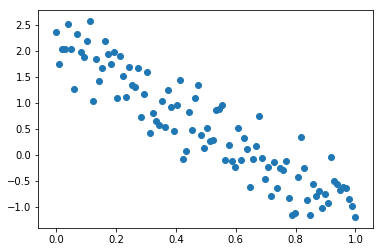

In [29]:
X = np.linspace(0, 1, 100 )
m = -3
b = 2
noise_level = 2
Y = [m*x + b + noise_level*(1/2)*(r.random()-r.random()) for x in X]

plt.scatter(X,Y);

Number of iterations to convergence: 356
[-3.25088484  2.15318413]


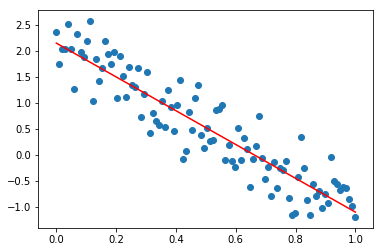

In [38]:
P, Losses, Deltas, SlopesIntercepts = linear_regression(X,Y,step_size=.005)
plt.scatter(X,Y)
plt.plot(X,[P[0]*x+P[1] for x in X],'r')
print(P)
plt.show();

# Try playing around with the step size to see how it effects convergence.
# You will probably get an error if you make it too large.

# Note: If the step size is decreased to much, then the gradient descent will not converge!

Looks like it worked! Let's plot the loss function and gradient norms to get a feel for how things converge.

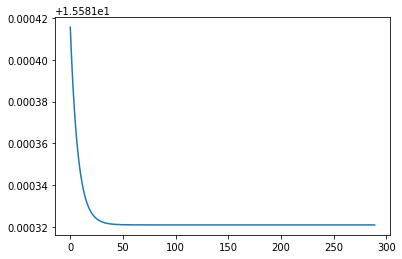

In [31]:
plt.plot(Losses[100:]);

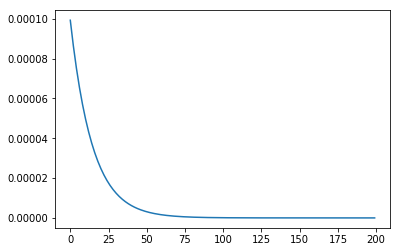

In [21]:
plt.plot(Deltas[100:]);

We can also plot several steps along the gradient descent path.

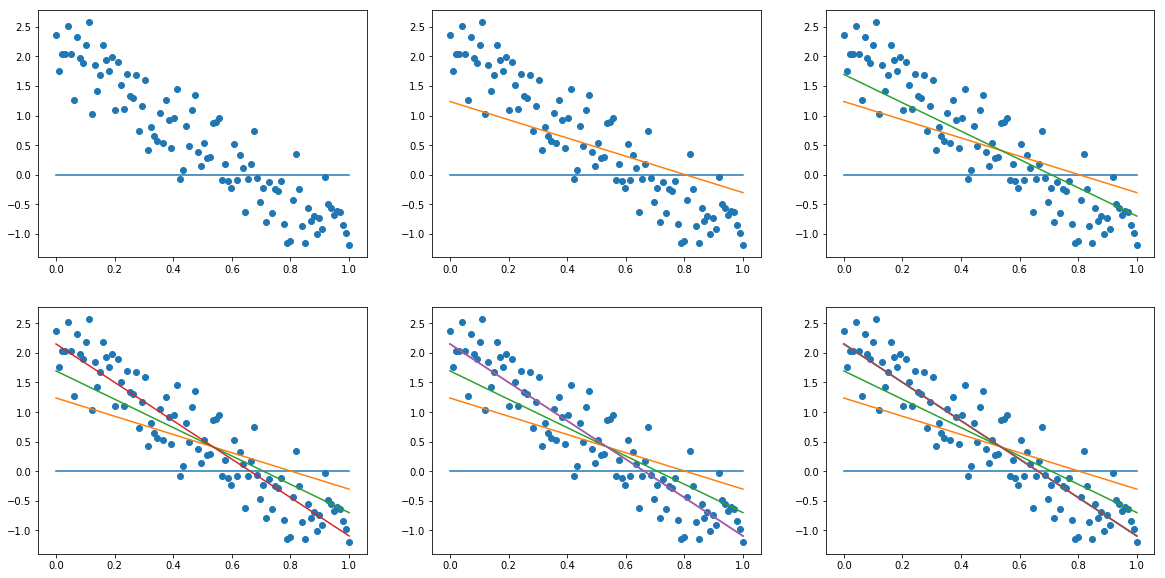

In [32]:
steps = [0, 10, 20, 100, 200, 299]

fig = plt.figure(figsize = (20,10))

for j in range(6):
    p = fig.add_subplot(2,3,j+1)
    p.scatter(X,Y)
    for k in range(j+1):
        p.plot(X,[SlopesIntercepts[steps[k]][0]*x+SlopesIntercepts[steps[k]][1] for x in X])

We can also take a look at how the slopes $m$ and interecepts $b$ evolve over the gradient descent procedure.

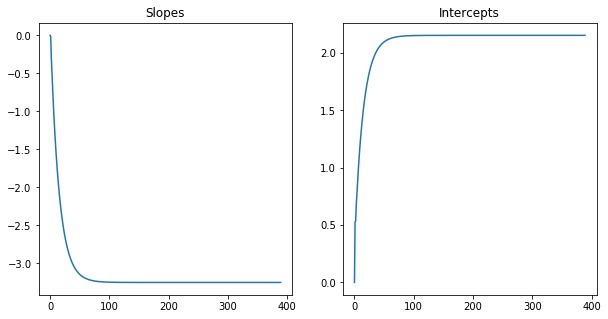

In [34]:
slopes = [P[0] for P in SlopesIntercepts]
intercepts = [P[1] for P in SlopesIntercepts]

fig = plt.figure(figsize = (10,5))

p1 = fig.add_subplot(1,2,1)
p1.plot(slopes)
plt.title('Slopes')

p2 = fig.add_subplot(1,2,2)
p2.plot(intercepts)
plt.title('Intercepts')

plt.show()

### Exercise

Take a second to run through this experiment again with different parameter values. E.g., change the slope/intercept in the toy data. Also change around the step size. How does the performance of the algorithm change?

## The $R^2$ Statistic

The linear function $f(x) = m x + b$ that we found via linear regression is called a *model* for our data. We can measure the "goodness-of-fit" of the model by the *$R^2$ value*. This is given by
$$
R^2 = 1 - \frac{\sum_j (y_j - (mx_j + b))^2}{\sum_j (y_j - \mu_Y)^2} = 1 - \frac{L(m,b)}{\sum_ j(y_j - \mu_Y)^2}.
$$
The numerator in the fraction term is just the SSR loss function applied to the minimizing $m$ and $b$. The denominator normalizes this loss by a measure of the variability in the data.

In [39]:
# Define the R2 function
def RSquared(X,Y,m,b):
    muY = sum(Y)/len(Y)
    centeredY = [y-muY for y in Y]
    return 1 - loss(X,Y,m,b)/sum([y**2 for y in centeredY])

In [40]:
RSquared(X,Y,P[0],P[1])

0.8522106533322108

We can run this experiment a few times for different noise levels.

In [41]:
noise_levels = [.01, 1, 2, 3, 4, 5, 20]

X = np.linspace(0, 1, 100 )
m = -3
b = 2

for noise_level in noise_levels:
    Y = [m*x + b + noise_level*(1/2)*(r.random()-r.random()) for x in X]
    P = linear_regression(X,Y,step_size=.005, verbose = False)
    print(RSquared(X,Y,P[0],P[1]))

Number of iterations to convergence: 281
0.9999932413545716
Number of iterations to convergence: 340
0.9457600930211206
Number of iterations to convergence: 346
0.8006205249264792
Number of iterations to convergence: 370
0.6493330948290248
Number of iterations to convergence: 354
0.5461114799568978
Number of iterations to convergence: 384
0.3604798519810023
Number of iterations to convergence: 388
0.01783593756166102


## Exact Solution

Linear regression is essentially unique among real-world optimization problems in that it has an analytic, exact solution. Indeed, we are searching for $(m,b)$ such that the gradient vector is zero:
$$
0 = \left( 2 \sum_j (m x_j + b - y_j) x_j, 2 \sum_j (m x_j + b - y_j) \right).
$$
This gives a system of equations in the variables $m$ and $b$:
\begin{align*}
0 &= \sum_j (m x_j + b - y_j) x_j = m \sum_j x_j^2 + b \sum_j x_j - \sum_j x_j y_j \\
0 &= \sum_j (m x_j + b - y_j) = m \sum_j x_j + b \sum_j 1 - \sum_j y_j.
\end{align*}
These can be solved expicitly, and we get
\begin{align*}
m &= \frac{\sum_j x_j y_j - \frac{1}{n} \sum_j x_j \sum_j y_j}{\sum_j x_j^2 - \frac{1}{n} (\sum_j x_j)^2} \\
b &= \frac{1}{n} \sum_j y_j - m \frac{1}{n} \sum_j x_j.
\end{align*}

### Exercise

Write functions `exact_m` and `exact_b` which compute the linear regression parameters according to the above formulas. Check that these give the same result as the gradient descent algorithm.

In [42]:
def exact_m(X,Y):
    numerator = sum(np.array(Y)*np.array(X))-1/len(X)*sum(Y)*sum(X)
    denominator = sum([x**2 for x in X]) - 1/len(X)*sum(X)**2
    return numerator/denominator

def exact_b(X,Y):
    return 1/len(X)*sum(Y)-exact_m(X,Y)/len(X)*sum(X)

In [44]:
X = np.linspace(0, 1, 100 )
m = -3
b = 2
noise_level = 2
Y = [m*x + b + noise_level*(1/2)*(r.random()-r.random()) for x in X]

P = linear_regression(X,Y,step_size=.005, verbose = False)

print(P[0], P[1])
print(exact_m(X,Y),exact_b(X,Y))

Number of iterations to convergence: 363
-3.0643215378909936 2.020011177732594
-3.064321537897266 2.0200111777359555


## Why Use Gradient Descent?

For the 1-dimensional regression problem, gradient descent is not that useful. The reasons we spent time on it are:

1) For most optimization problems, it is not possible to find an analytical solution. In these cases numerical methods are necessary, and gradient descent is the simplest option. Much of the time gradient descent is sufficient to get a fast and accurate solution.

2) In higher dimensional linear regression problems (which we will discuss below), there is still an analytical solution (called the *normal equation*). In higher dimensions, the equation involves matrix inversion, which is computationally costly. So even though an exact solution exists, it is frequently computationally faster to do gradient descent.

### Exercise

Load the 'galton' height data from yesterday and run linear regression on it. In particular, once again add a 'midparent' column to the dataframe (as we did yesterday), and run regression with $X$ the midparent data and $Y$ the child height data. Plot the scatter plot and the regression line. 

What $R^2$ value do you get?

Use your model to predict the height of a child with midparent height 70 inches.

<b> Remark: </b> You can try doing this with gradient descent, but I found it to be pretty touchy and couldn't get it to converge. The exact solution should work though! See further remarks at the end.

In [46]:
import pandas as pd

df = pd.read_csv('data/galton.csv')
df['midparent'] = (df.father + df.mother)/2

R^2 = 0.10697736868526408
slope = 0.6692588951333257, intercept = 22.14880916448933


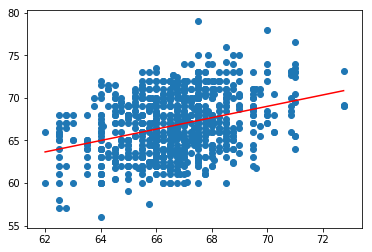

In [47]:
X = list(df.midparent)
Y = list(df.height)

m = exact_m(X,Y)
b = exact_b(X,Y)
print('R^2 = '+str(RSquared(X,Y,m,b)))
print('slope = '+str(m)+',','intercept = '+str(b))

xs = np.linspace(df.midparent.min(),df.midparent.max(),100)

plt.plot(xs,[m*x+b for x in xs], color = 'red')
plt.scatter(X,Y)
plt.show();

In [49]:
P, Losses, Deltas, SlopesIntercepts = linear_regression(X,Y,step_size = 5e-7,num_iter = 10000)
plt.scatter(X,Y)
plt.plot(X,[P[0]*x+P[1] for x in X],'r')
plt.show()

# Note this didn't actually converge to a small enough gradient.
# We should also boost up the max number of iterations, but this takes long enough already.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract


KeyboardInterrupt: 

# Cross-Correlation and SciKitLearn



Of course, there are already built-in packages which can perform linear regression for us! The package `scikit-learn` is popular for regression and other techniques in supervised learning. *Supervised learning* means learning the relationship between two sets
of data: the observed data $X$ and an external variable $y$ that we
are trying to predict.  Often $y$ is called the *target* (for
regression) or *labels* (for classification).  Let's load some code
from `scikit-learn` to perform linear regression.

In [50]:
from sklearn.linear_model import LinearRegression

Supervised estimators in `scikit-learn` (like `LinearRegression`)
implement a `fit` method to fit the model and a `predict` method that
converts observations into predicted targets or labels.

Let's check our work on the 'galton' height data using the model from `scikit-learn`.

In [51]:
lm = LinearRegression().fit( df[['midparent']], df['height'] )
# Options for LinearRegression() can be put in the parentheses

In [55]:
type(lm)

sklearn.linear_model.base.LinearRegression

Observe the syntax above. The 'midparent' variables are passed in as a dataframe, while the 'height' response variables are passed in as a series.

In [52]:
print(type(df[['midparent']]),type(df['height']))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


Our linear model has 'attributes' `coef_` and `intercept_`, which we access using the following code. The results here should agree with what you computed above!

In [53]:
print(lm.coef_, lm.intercept_)

[0.6692589] 22.148809164541376


We can also compute the $R^2$ statistic (once again, this should agree with your earlier computation).

In [54]:
lm.score(df[['midparent']],df['height'])

0.10697736868526164

## Is this any good?



By &ldquo;any good&rdquo; we mean: is our model valid?  To evaluate the
performance of the model, we would need to test it on some unseen
data&#x2026; but we aren&rsquo;t going to find children and their parents and
measure their heights.

*Cross-validation* is a solution to the question of &ldquo;validity&rdquo; of
the model, and also a solution to our not having unseen data.  Instead
of running `fit` on all the data, we keep aside some portion of the
data and use that &ldquo;hold-out&rdquo; data for validation.

To be more specific, there are various ways of arranging for this.  We
might split the data into a training set and a testing set. 

Another method is **k-fold cross-validation** in which the original data
is partitioned (randomly) into $k$ equal sized subsamples. Of the $k$
subsamples, a single subsample is retained as the validation data for
testing the model, and the remaining $k-1$ subsamples are used as
training data.  Conveniently, `scikit-learn` has methods for this.



In [56]:
from sklearn.model_selection import KFold

Let's use it. We'll use $5$-folds, meaning that we split the data into five subsets, each of which will be used as the testing data in one trial.

In [57]:
model = LinearRegression() # Choose Linear Regression as our model
scores = [] # Initialize an empty list to hold R^2 scores

X = df[['midparent']]
y = df['height']

kf = KFold(n_splits=5, shuffle=True, random_state=1)
# Define the kFold Splits

`kf` contains 5 lists of training indices and 5 corresponding lists of testing indices. For each trial, 80% of the records (contained in the training indices) are used to train a model. The goodness-of-fit of this model is checked (via $R^2$ score) on the remaining 20% of the records. This gives us a list of five $R^2$ scores, which gives us an idea of how well a linear model does for prediction. 

In [58]:
for train_index, test_index in kf.split(X):
    print(len(train_index), len(test_index))

718 180
718 180
718 180
719 179
719 179


In [59]:
scores = []

# Split again so we can rerun this cell and get some randomness
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

scores

[0.08405816314737391,
 0.1081277742956952,
 0.08533372381996018,
 0.12864783606331065,
 0.1223630213038146]

Those $R^2$ scores are not especially reassuring.  Can we do better?
Are we missing something in our model?



## Linear Regression in General

In the general linear regression problem, our set of *explanatory variables* $X = \{\vec{x}_1,\ldots,\vec{x}_n\}$ consists of vectors $\vec{x}_j \in \mathbb{R}^d$. The entries of each vector are traditionally called *features*. Our set of *response variables* $Y = \{y_1,\ldots,y_n\}$ still contains scalars. We now suspect that the response variables are determined linearly by the features as
$$
y_j \approx \beta_1 x_j^1 + \beta_2 x_j^2 + \cdots + \beta_d x_j^d + b,
$$
where $\vec{x}_j = (x_j^1,x_j^2,\ldots,x_j^d)$ and the $\beta_j$ and $b$ are real numbers. Our goal is to determine these $\beta_j$ and $b$.

Once again, we define a *loss function* by
$$
L(\beta_1,\ldots,\beta_d,b) = \sum_{j=1}^n \left(\beta_1 x_j^1 + \beta_2 x_j^2 + \cdots + \beta_d x_j^d + b - y_j\right)^2.
$$

Since $X$ and $Y$ are fixed, this is once again an optimization problem in the $\vec{\beta}$ and $b$. It can be solved by gradient descent (or, for large datasets, a variant called *stochastic gradient descent*), much as we did before. There is still an exact solution to this higher-dimensional version (called the *normal equation*), but as we mentioned above, it might be more computationally efficient to use gradient descent.

### Exercise 

Adapt the code above to create a linear model whose features are both the mother's and the father's heights and whose response variables are the children's heights. 

Look at the coefficients in your model. Do these have any interesting interpretation?

Run kFold cross-validation to quantify the performance of the model.

In [571]:
X = df[['mother','father']]
y = df.height

In [572]:
lm = LinearRegression().fit(X,y)

In [573]:
lm.coef_
# The Father's height apparently has a larger effect on the child's height.

array([0.28321451, 0.37989697])

In [574]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

scores

[0.08787227334178815,
 0.1119544250198562,
 0.08801656226354948,
 0.13063452401419473,
 0.11762888033766629]

### Exercise

Use `seaborn` to load the dataset `mpg`. Try to create a multiple linear model with the best possible predictive power for acceleration. 

If you get done with that, take a look at some of the other datasets built in to `seaborn`: https://github.com/mwaskom/seaborn-data

In [575]:
import seaborn as sns
mpg = sns.load_dataset("mpg")

In [576]:
mpg2 = mpg.dropna()

In [578]:
mpg2.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316
model_year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000


In [582]:
X = mpg2[['mpg','displacement','horsepower','weight']]
y = mpg2['acceleration']

In [583]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

scores

[0.6030012159260334,
 0.5774551873057142,
 0.5782638379987677,
 0.6578161385990631,
 0.5963934497359675]

In [584]:
lm = LinearRegression().fit(X,y)

In [585]:
lm.coef_

array([-0.0037912 , -0.01004659, -0.08368949,  0.00305059])

In [ ]:
import seaborn as sns
mpg = sns.load_dataset("mpg")

mpg2 = mpg.dropna()

mpg2.corr()

X = mpg2[['mpg','displacement','horsepower','weight']]
y = mpg2['acceleration']

kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

scores

lm = LinearRegression().fit(X,y)

lm.coef_

### Exercise/Homework

Write a better gradient descent algorithm that will actually converge for the Galton height data. To fix the convergence issue, we should really be updating the step size as we go; e.g., one standard approach is to do a *line search* https://en.wikipedia.org/wiki/Line_search